In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
DATASET_DIR = "PlantVillage"  # path to dataset folder
IMAGE_SIZE = (256, 256)       # resize images
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'

In [3]:
def extract_color_features(image):
    """Extract mean and std of RGB & HSV + color histogram."""
    features = []
    
    # RGB mean/std
    for i in range(3):
        features.append(np.mean(image[:, :, i]))
        features.append(np.std(image[:, :, i]))
    
    # HSV mean/std
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    for i in range(3):
        features.append(np.mean(hsv[:, :, i]))
        features.append(np.std(hsv[:, :, i]))
    
    # Color histogram (HSV, 8 bins each)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    features.extend(hist)
    
    return features

def extract_texture_features(image):
    """Extract texture features using Local Binary Patterns."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, LBP_POINTS + 3),
                             range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalize
    return hist.tolist()

def extract_shape_features(image):
    """Extract shape features: aspect ratio, extent, solidity."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return [0, 0, 0]
    
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = float(w) / h
    area = cv2.contourArea(c)
    rect_area = w * h
    extent = float(area) / rect_area if rect_area != 0 else 0
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0
    
    return [aspect_ratio, extent, solidity]

In [4]:
data = []
labels = []

for folder in os.listdir(DATASET_DIR):
    folder_path = os.path.join(DATASET_DIR, folder)
    if not os.path.isdir(folder_path):
        continue
    
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        if image is None:
            continue
        
        image = cv2.resize(image, IMAGE_SIZE)
        
        color_feats = extract_color_features(image)
        texture_feats = extract_texture_features(image)
        shape_feats = extract_shape_features(image)
        
        features = color_feats + texture_feats + shape_feats
        data.append(features)
        labels.append(folder)


In [5]:
df = pd.DataFrame(data)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(df, labels_encoded,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=labels_encoded)

In [6]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.966327519379845
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.97      0.97       199
                     Pepper__bell___healthy       0.95      0.99      0.97       296
                      Potato___Early_blight       0.99      0.95      0.97       200
                       Potato___Late_blight       0.93      0.96      0.95       200
                           Potato___healthy       1.00      0.80      0.89        30
                      Tomato_Bacterial_spot       0.96      0.97      0.96       426
                        Tomato_Early_blight       0.95      0.85      0.90       200
                         Tomato_Late_blight       0.96      0.95      0.96       382
                           Tomato_Leaf_Mold       0.98      0.99      0.99       190
                  Tomato_Septoria_leaf_spot       0.96      0.97      0.96       354
Tomato_Spider_mites_Two_spotted_spid

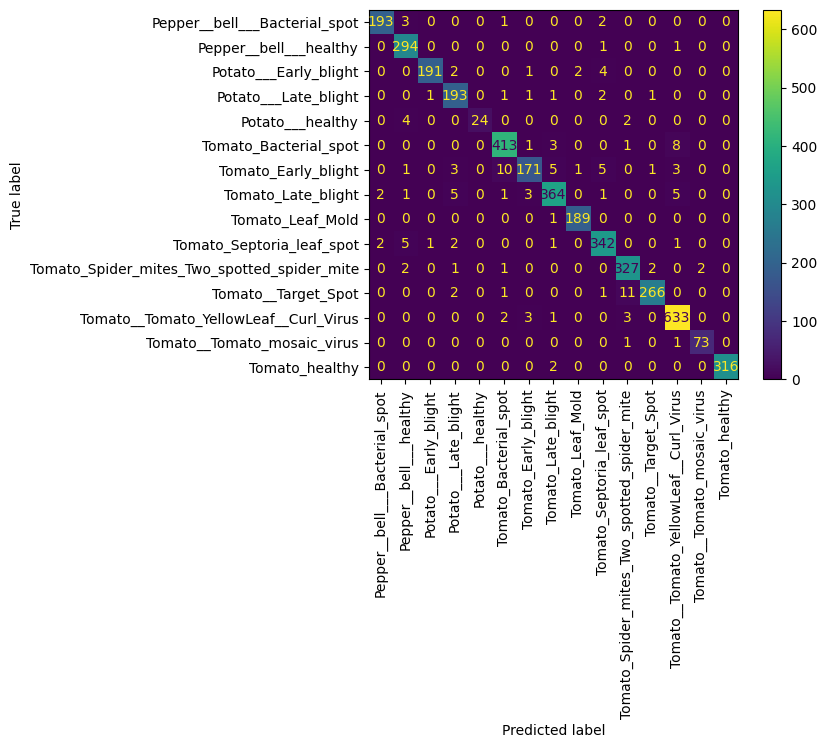

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='viridis', xticks_rotation=90)

In [8]:
# ======== CUSTOM INPUT PREDICTION ========

def predict_leaf(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not found or invalid path!")
        return
    
    image = cv2.resize(image, IMAGE_SIZE)

    color_feats = extract_color_features(image)
    texture_feats = extract_texture_features(image)
    shape_feats = extract_shape_features(image)
    
    features = np.array(color_feats + texture_feats + shape_feats).reshape(1, -1)
    prediction = clf.predict(features)
    predicted_label = le.inverse_transform(prediction)[0]
    
    print(f"Predicted Class: {predicted_label}")

# Example usage:
predict_leaf("0a3d19ca-a126-4ea3-83e3-0abb0e9b02e3___YLCV_GCREC 2449.jpg")

Predicted Class: Tomato__Tomato_YellowLeaf__Curl_Virus


In [ ]:
import joblib

joblib.dump(clf, 'Plant_Disease_Classifier')